# Problem Statement:
The attached logins.json file contains (simulated) timestamps of user logins in a particular
geographic location. Aggregate these login counts based on 15minute time intervals, and
visualize and describe the resulting time series of login counts in ways that best characterize the
underlying patterns of the demand. Please report/illustrate important features of the demand,
such as daily cycles. If there are data quality issues, please report them.

In [1]:
# import
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import itertools

In [2]:
# load and preview data
file = 'logins.json'
logins = pd.read_json(file)
logins.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


It can be seen from just the first few entries, that the login times are not in chronological order.

In [3]:
def bin_logins_into_intervals(login_time, interval_time_delta):
    # get first and last times
    first_time = login_time.sort_values(ascending=True).iloc[0]
    last_time = login_time.sort_values(ascending=True).iloc[-1]
    
    # get base of first time
    first_time_base = dt.datetime(first_time.year,
                                  first_time.month,
                                  first_time.day,
                                  hour=0,
                                  minute=0)
    
    # create array of interval beginnings
    interval_beginnings = [first_time_base]
    
    # override interval beginnings until an appropriate interval beginning is reached
    while interval_beginnings[-1] < (first_time - interval_time_delta):  # subtract interval_time_delta to counter the addition
        interval_beginnings[-1] = interval_beginnings[-1] + interval_time_delta
    
    # now continue with building the array
    while interval_beginnings[-1] < last_time:
        interval_beginnings.append(interval_beginnings[-1] + interval_time_delta)
    
    # do the binning
    binned_logins = pd.cut(login_time, bins=pd.IntervalIndex.from_tuples(
        [ (interval_beginnings[i], interval_beginnings[i+1]) for i in range(len(interval_beginnings) - 1) ]
    ))
    
    return binned_logins

In [4]:
# get binned logins
logins['15_min_binning'] = bin_logins_into_intervals(logins['login_time'], dt.timedelta(minutes=15))

In [5]:
# aggregate binned logins
aggregated_logins_15_min = logins[['login_time', '15_min_binning']].groupby('15_min_binning').agg('count')
aggregated_logins_15_min.rename({'login_time':'count'}, axis=1, inplace=True)
aggregated_logins_15_min.reset_index(inplace=True)
aggregated_logins_15_min.head()

,15_min_binning,count
0,"(1970-01-01 20:00:00, 1970-01-01 20:15:00]",2
1,"(1970-01-01 20:15:00, 1970-01-01 20:30:00]",6
2,"(1970-01-01 20:30:00, 1970-01-01 20:45:00]",9
3,"(1970-01-01 20:45:00, 1970-01-01 21:00:00]",7
4,"(1970-01-01 21:00:00, 1970-01-01 21:15:00]",1


In [6]:
# returns list of edges from interval data
def get_edges_from_intervals(series_of_intervals):
    list_of_tuples = [(i.left, i.right) for i in series_of_intervals]
    edges = sorted(list(set(itertools.chain.from_iterable(list_of_tuples))))
    return edges

In [7]:
# create data to use in stairs() plot
values = aggregated_logins_15_min['count']  # aggregated counts of logins per interval
edges = get_edges_from_intervals(aggregated_logins_15_min['15_min_binning'])  # interval left and right bounds

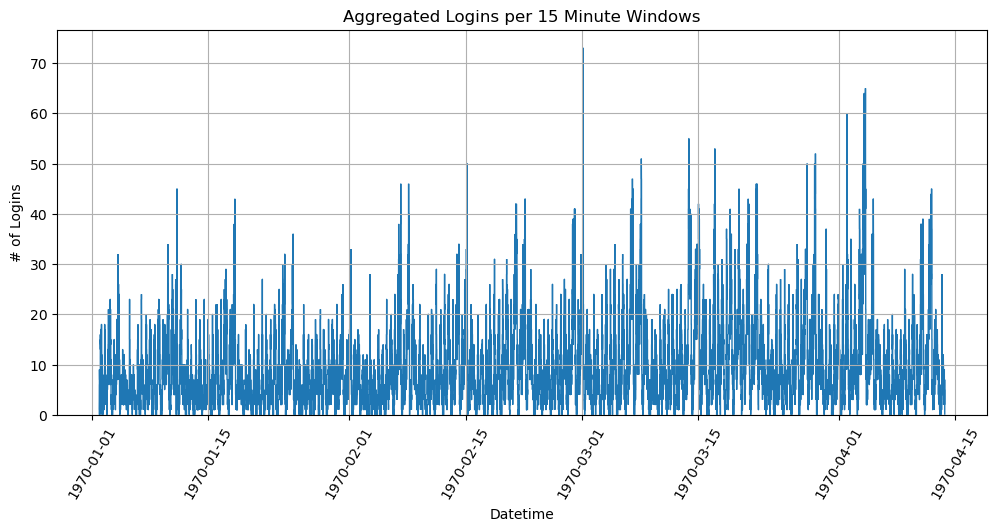

In [8]:
# do the stair plotting
fig, ax = plt.subplots(figsize=(12,5))
plt.stairs(values, edges)
plt.xticks(rotation=60)
plt.grid(True)
ax.set_xlabel('Datetime')
ax.set_ylabel('# of Logins')
ax.set_title('Aggregated Logins per 15 Minute Windows')
plt.show()

There appears to be a degree of seasonality in the aggregated login data. Let's also plot the rolling average.

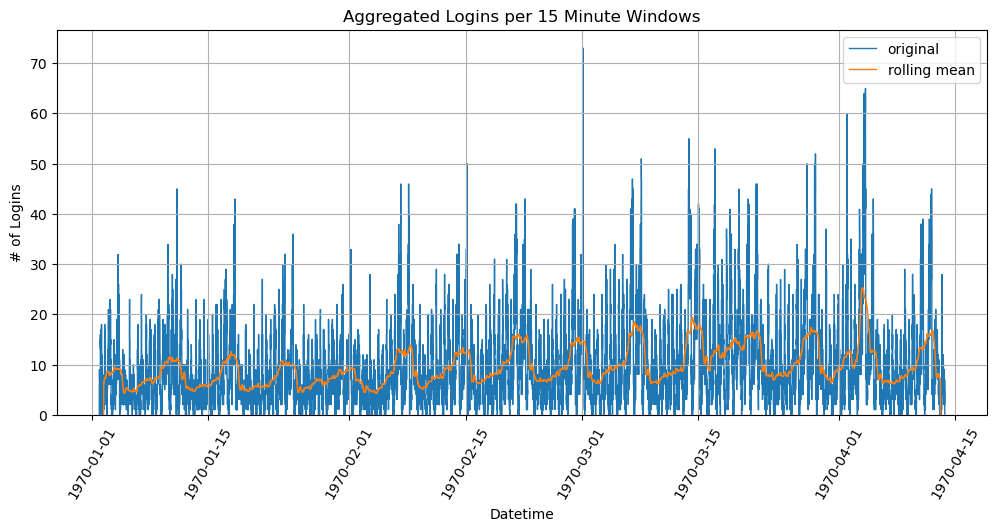

In [16]:
fig, ax = plt.subplots(figsize=(12,5))
ax.stairs(values, edges)
ax.stairs(values.rolling(window=100, center=True).mean(), edges)
plt.xticks(rotation=60)
ax.grid(True)
ax.legend(['original', 'rolling mean'])
ax.set_xlabel('Datetime')
ax.set_ylabel('# of Logins')
ax.set_title('Aggregated Logins per 15 Minute Windows')
plt.show()

Adding the rolling average to the plot allows us to more easily visualize the seasonality in login times. There are clearly windows of high logins folled by windows of reduced logins.

Let's look at what one week of logins looks like, aggregated every 15 minutes.

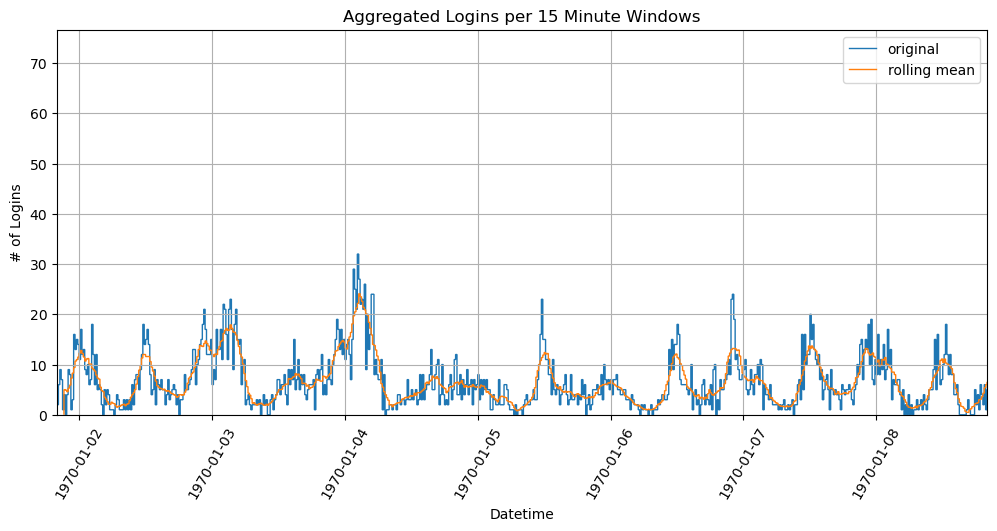

In [10]:
fig, ax = plt.subplots(figsize=(12,5))
ax.stairs(values, edges)
ax.stairs(values.rolling(window=10, center=True).mean(), edges)
plt.xticks(rotation=60)
ax.grid(True)
ax.set_xlim([edges[0], edges[0] + dt.timedelta(days=7)])
ax.legend(['original', 'rolling mean'])
ax.set_xlabel('Datetime')
ax.set_ylabel('# of Logins')
ax.set_title('Aggregated Logins per 15 Minute Windows')
plt.show()

Now, let's overlay each week on the plot to see if there is autoregressive behavior.

In [11]:
# get collections of weekly data
first_day = dt.datetime(logins['login_time'].sort_values(ascending=True).iloc[0].year,
                        logins['login_time'].sort_values(ascending=True).iloc[0].month,
                        logins['login_time'].sort_values(ascending=True).iloc[0].day,
                        hour=0,
                        minute=0)
last_day = dt.datetime(logins['login_time'].sort_values(ascending=True).iloc[-1].year,
                       logins['login_time'].sort_values(ascending=True).iloc[-1].month,
                       logins['login_time'].sort_values(ascending=True).iloc[-1].day,
                       hour=0,
                       minute=0)
# initialize day
day = first_day
week = 0
data_dict_values = {}
data_dict_edges = {}
while day < last_day:
    # record weekly data
    weekly_mask = [((i.left > day) & (i.right <= day + dt.timedelta(days=7))) for i in aggregated_logins_15_min['15_min_binning']]
    data_dict_values['week'+str(week)] = aggregated_logins_15_min['count'][weekly_mask]  # aggregated counts of logins per interval
    data_dict_edges['week'+str(week)] = [(i - dt.timedelta(days=7*week)) for i in get_edges_from_intervals(aggregated_logins_15_min['15_min_binning'][weekly_mask])]  # interval left and right bounds reset to initial week
    
    # iterate day
    day = day + dt.timedelta(days=7)
    week = week + 1

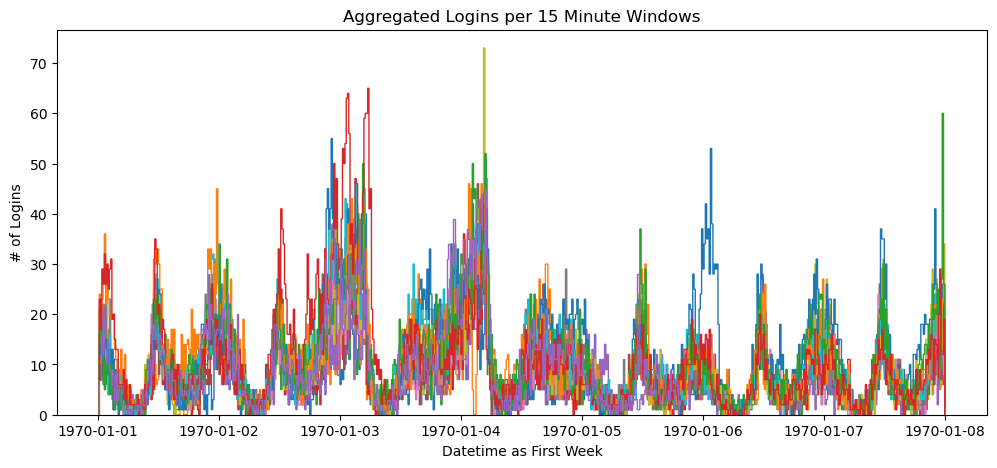

In [12]:
# view all weekly data overlapped
fig, ax = plt.subplots(figsize=(12,5))

for key in data_dict_values.keys():
    ax.stairs(data_dict_values[key], data_dict_edges[key])

# ax.legend(data_dict_values.keys(), loc='best')
ax.set_xlabel('Datetime as First Week')
ax.set_ylabel('# of Logins')
ax.set_title('Aggregated Logins per 15 Minute Windows')
plt.show()

Yes, there is autoregressive behavior exhibited on the weekly level. Let's also look at the daily data overlapped.

In [13]:
# get collections of daily data
first_day = dt.datetime(logins['login_time'].sort_values(ascending=True).iloc[0].year,
                        logins['login_time'].sort_values(ascending=True).iloc[0].month,
                        logins['login_time'].sort_values(ascending=True).iloc[0].day,
                        hour=0,
                        minute=0)
last_day = dt.datetime(logins['login_time'].sort_values(ascending=True).iloc[-1].year,
                       logins['login_time'].sort_values(ascending=True).iloc[-1].month,
                       logins['login_time'].sort_values(ascending=True).iloc[-1].day,
                       hour=0,
                       minute=0)
# initialize day
day = first_day
day_count = 0
data_dict_values = {}
data_dict_edges = {}
while day <= last_day:
    # record daily data
    daily_mask = [((i.left > day) & (i.right <= day + dt.timedelta(days=1))) for i in aggregated_logins_15_min['15_min_binning']]
    data_dict_values['day'+str(day_count)] = aggregated_logins_15_min['count'][daily_mask]  # aggregated counts of logins per interval
    data_dict_edges['day'+str(day_count)] = [(i - dt.timedelta(days=1*day_count)) for i in get_edges_from_intervals(aggregated_logins_15_min['15_min_binning'][daily_mask])]  # interval left and right bounds reset to initial day
    
    # iterate day
    day = day + dt.timedelta(days=1)
    day_count = day_count + 1

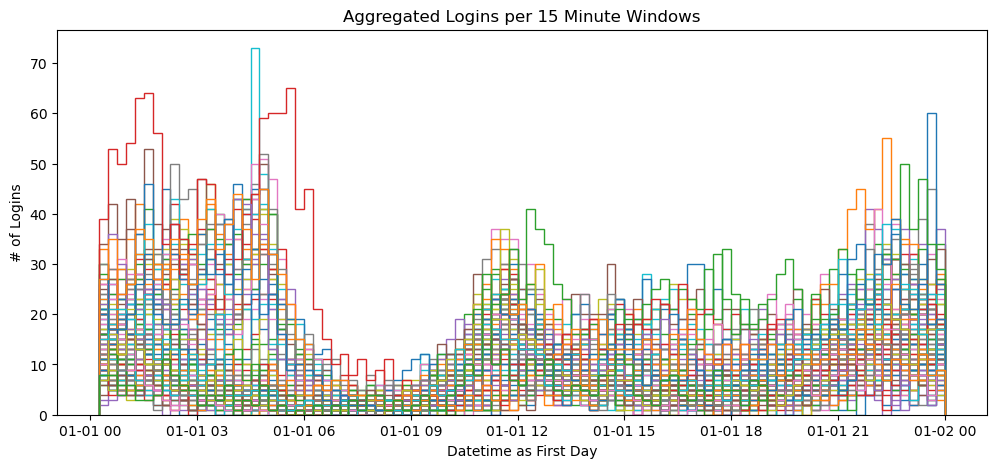

In [14]:
# view all daily data overlapped
fig, ax = plt.subplots(figsize=(12,5))

for key in data_dict_values.keys():
    ax.stairs(data_dict_values[key], data_dict_edges[key])

# ax.legend(data_dict_values.keys(), loc='best')
ax.set_xlabel('Datetime as First Day')
ax.set_ylabel('# of Logins')
ax.set_title('Aggregated Logins per 15 Minute Windows')
plt.show()

There is also autoregressive behavior visible at the daily level, although it gets harder to view when zoomed in this much. A clear low login time is roughly between the 6th and 9th hours of each day.

### Summary

There is definitely a repeating pattern in login times. It can easily be seen on the weekly and daily levels. It should also be noted that the original .json file does not have the login times in chronological order.